# 多層パーセプトロンによる2クラス分類問題

In [1]:
from __future__ import unicode_literals
from __future__ import print_function
import sys
import os
import math
import random
import pandas as pd
import numpy as np
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (9, 6) # グラフの表示サイズを変更

In [2]:
sys.version_info

sys.version_info(major=2, minor=7, micro=13, releaselevel='final', serial=0)

## Chainerをロード

In [3]:
import chainer
from chainer import Variable, Function, Link, optimizers
import chainer.functions as F
import chainer.links as L

In [4]:
chainer.__version__

'1.21.0'

## データをロード

In [5]:
df = pd.read_csv('ex2data2.txt', names=('test1', 'test2', 'result'))

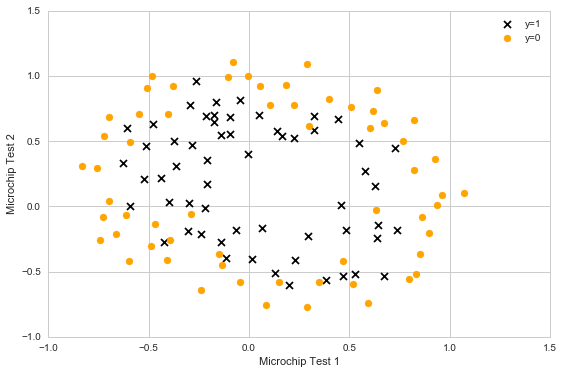

In [6]:
def plot_dataset():
    pos = df.ix[df['result'] == 1]
    neg = df.ix[df['result'] == 0]
    
    fig = plt.figure()
    plt.xlim(-1., 1.5)
    plt.ylim(-1., 1.5)
    ax = fig.add_subplot(1,1,1)
    ax.scatter(pos['test1'], pos['test2'], color='black', marker='x', label='y=1')
    ax.scatter(neg['test1'], neg['test2'], color='orange', marker='o', label='y=0')
    ax.legend()
    ax.set_xlabel('Microchip Test 1')
    ax.set_ylabel('Microchip Test 2')
    return ax

plot_dataset()

## Feature mapping

In [7]:
def map_feature(X1, X2):

    assert(X1.shape == X2.shape)
    
    m = X1.shape[0];
    degree = 6
    out = np.ones((m, 1))
    for i in range(1, degree+1):
        for j in range (0, i + 1):
            column = np.power(X1, i-j) * np.power(X2, j)
            out = np.c_[out, column]
    return out

In [8]:
x1 = np.array(df['test1']).reshape(-1, 1)
x2 = np.array(df['test2']).reshape(-1, 1)
xs = map_feature(x1, x2)

pd.DataFrame(xs).head(5)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


In [9]:
ys = np.array(df['result']).reshape(-1)

print (xs.shape, ys.shape)
print (type(xs), type(ys))

(118, 28) (118,)
<type 'numpy.ndarray'> <type 'numpy.ndarray'>


## ネットワークを定義

In [10]:
class MLP(chainer.Chain):
    def __init__(self, n_in, n_mid, n_out):
        super(MLP, self).__init__(
            fc_in  = L.Linear(n_in, n_mid),
            fc_mid = L.Linear(n_mid, n_mid),
            fc_out = L.Linear(n_mid, n_out)
        )
        self.train = True

    def __call__(self, x, y=None):
        h = F.sigmoid(self.fc_in(x))
        h = F.sigmoid(self.fc_mid(h))
        h = self.fc_out(h)
        
        if y is not None:
            self.loss = F.softmax_cross_entropy(h, y)
            self.accuracy = F.accuracy(h, y)
        
        if self.train:
            return self.loss
        else:
            return F.softmax(h)

## モデルを学習

In [11]:
n_in = xs[0].shape[0]
n_mid = 10
n_out = 2

model = MLP(n_in, n_mid, n_out)
optimizer = optimizers.SGD(lr=0.3)
optimizer.setup(model)

n_in, n_mid, n_out

(28, 10, 2)

In [12]:
def one_epoch(model, optimizer, xs, ys):
    volatile = 'off' if model.train else 'on'
    x = Variable(xs.astype(np.float32), volatile=volatile)
    y = Variable(ys.astype(np.int32), volatile=volatile)
    
    if model.train:
        optimizer.update(model, x, y)
        return model.loss
    else:
        return model(x, y)

    
n_iter = 2000
learning_curve = []

for count in range(1, n_iter+1):
    one_epoch(model, optimizer, xs, ys)
    train_loss = model.loss.data
    train_acc  = model.accuracy.data
    
    sys.stdout.write('\rlearning : {0} {1} {2} ...'.format(count, train_loss, train_acc))
    sys.stdout.flush()
    learning_curve.append({'train_loss': train_loss, 'train_acc': train_acc})

learning : 2000 0.32154032588 0.838983058929 ....

## 学習曲線をプロット

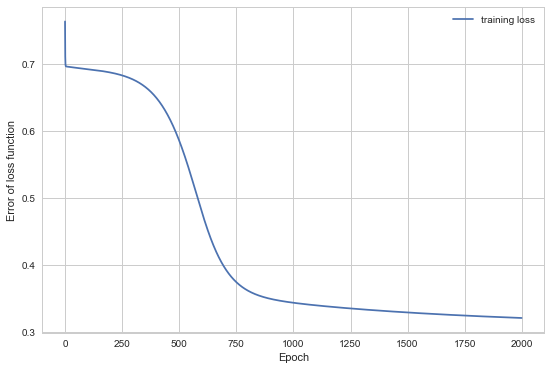

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot([c['train_loss'] for c in learning_curve], label='training loss')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Error of loss function')

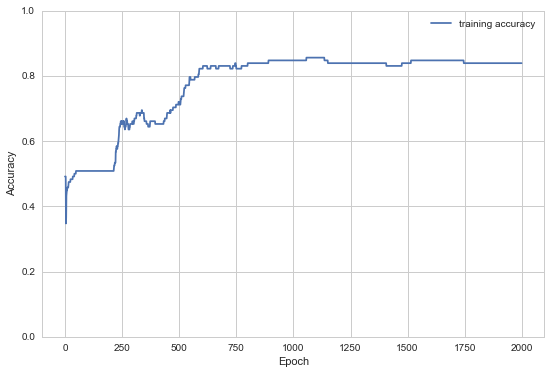

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_ylim(0., 1.)
ax.plot([c['train_acc'] for c in learning_curve], label='training accuracy')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

## 決定境界をプロット

In [15]:
gridsize = 100
xs1, xs2 = np.meshgrid(np.linspace(-1, 1.5, gridsize),
                       np.linspace(-1, 1.5, gridsize))

def compute_boundary(model, xs1, xs2, gridsize):
    model.train = False
    ys = np.zeros((gridsize, gridsize))
    for i in range(gridsize):
        for j in range(gridsize):
            x1 = np.array([xs1[i, j]])
            x2 = np.array([xs2[i, j]])
            pred = model(map_feature(x1, x2).astype(np.float32)).data[0]
            ys[i, j] = 0 if pred[0] >= pred[1] else 1
            #ys[i, j] = model(xs.astype(np.float32)).data
    return ys

def plot_boundary(xs1, xs2, ys):
    ax = plot_dataset()
    plt.jet()
    ax.contour(xs1, xs2, ys, levels=[0])
    ax.legend()

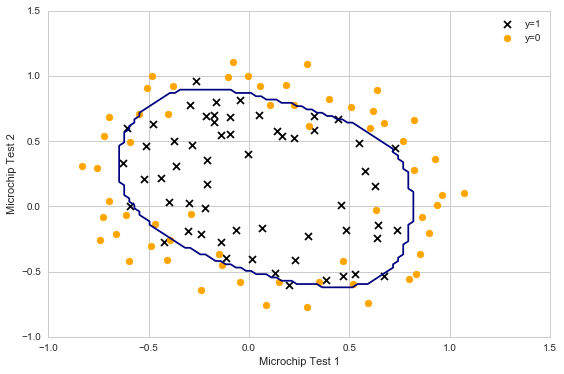

In [16]:
ys = compute_boundary(model, xs1, xs2, gridsize)
plot_boundary(xs1, xs2, ys)